In [1]:
!pip install transformers[torch]
!pip install -U datasets
!pip install -U transformers
!pip install -U accelerate
!pip freeze | grep accelerate
#Must use GPU

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import os.path
import matplotlib.pyplot as plt

In [25]:
# Load the emotion analysis dataset
#dataset_file_name = os.path.join('drive','MyDrive','Project 3 - NLP',"emotion_sentimen_dataset.csv")
dataset_file_name = '/content/drive/MyDrive/Project 3 - NLP/emotion_sentimen_dataset.csv'

# Check if the dataset file exists
if not os.path.exists(dataset_file_name):
    raise FileNotFoundError(f"Dataset file not found: {dataset_file_name}")

# Load the dataset and check if it's empty
dataset = pd.read_csv(dataset_file_name)
if dataset.empty:
    raise ValueError("The dataset is empty. Please check the file content.")

# Only use the first 10K entreis
dataset = dataset.head(10000)

In [ ]:
dataset.head()

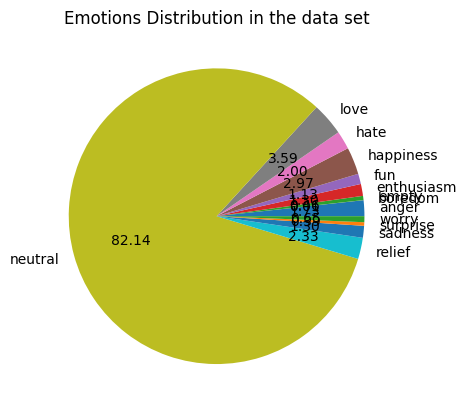

In [6]:
import numpy as np
###===== Part 1.1 =======
#Draw a pie plot using matplotlib of all the possible emotions
dataset.Emotion.unique()
df = pd.DataFrame(dataset.Emotion.value_counts())
df
# group by Emotion and get counts
emotion_counts = dataset.groupby('Emotion').size()
# create pie chart
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%.2f')
plt.title("Emotions Distribution in the data set")
plt.show()

In this dataset, there is a strong imbalance where >80% of the dataset is labeled as ‘neutral’. Calculating the accuracy of an imbalanced dataset can be misleading, and therefore it is not advised to be used for measuring the success of a classification algorithm for this dataset.
In contrast, precision and recall offer a more nuanced evaluation of a model performance.
An inaccurate model might just always return the majority class, and the percentage of the majority class will be equal to the accuracy metric.


In [7]:
# Map emotions to 'neutral' and 'non-neutral'
dataset['Emotion'] = dataset['Emotion'].apply(lambda x: 0 if x == 'neutral' else 1)

In [8]:
import random
random.seed(42)
dataset['Type'] = ['Train' if random.random() < 0.8 else 'Test' for _ in dataset['Emotion']]

# Split dataset into train and test sets
train_texts = dataset[dataset['Type'] == "Train" ]['text']
train_labels = dataset[dataset['Type'] == "Train" ]['Emotion']

test_texts = dataset[dataset['Type'] == "Test" ]['text']
test_labels = dataset[dataset['Type'] == "Test" ]['Emotion']

In [9]:
percent_of_minority_train = np.mean(train_labels)*100
percent_of_minority_test = np.mean(test_labels)*100
print(f" {percent_of_minority_train:.2f}% in training set" )
print(f" {percent_of_minority_test:.2f}% in testing set" )

 17.71% in training set
 18.49% in testing set


In [10]:
# Prepare the dataset for the transformer
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': train_texts,
    'label': train_labels
}))
test_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': test_texts,
    'label': test_labels
}))

# Load pre-trained DistilBERT tokenizer and model
# DistilBERT is chosen for its efficiency in NLP tasks with fewer parameters
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Function that tokenize the dataset with padding and truncation to maintain consistent input sizes
def tokenize_data(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8031 [00:00<?, ? examples/s]

Map:   0%|          | 0/1969 [00:00<?, ? examples/s]

In [11]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    logging_dir='./logs',
    do_eval=True,
    evaluation_strategy="epoch"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.115900,0.078571
2,0.067300,0.060537
3,0.021900,0.072512
4,0.012200,0.066061
5,0.004500,0.077593


{'eval_loss': 0.07759270071983337, 'eval_runtime': 8.6336, 'eval_samples_per_second': 228.062, 'eval_steps_per_second': 28.609, 'epoch': 5.0}


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
###===== Part 1.3 =======
## Write a code that calculates the precision and recall on the training and testing dataset
# Function to calculate precision and recall
def compute_precision_recall(predictions, references):
    return (precision_score(references,predictions, average='weighted')), recall_score(references,predictions, average='weighted')))
###===== End of part 1.3 =======


# Predict outputs for the training dataset
train_output = trainer.predict(train_dataset)
train_predictions = train_output.predictions.argmax(-1)
train_references = train_output.label_ids

# Predict outputs for the testing dataset
test_output = trainer.predict(test_dataset)
test_predictions = test_output.predictions.argmax(-1)
test_references = test_output.label_ids

# Compute precision and recall for the training dataset
train_precision, train_recall = compute_precision_recall(train_predictions, train_references)
print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}")

# Compute precision and recall for the testing dataset
test_precision, test_recall = compute_precision_recall(test_predictions, test_references)
print(f"Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}")

conf_matrix = confusion_matrix(test_predictions, test_references)
print('Confusion Matrix:')
print(conf_matrix)

Training Precision: 0.9993, Training Recall: 0.9979
Testing Precision: 0.9859, Testing Recall: 0.9615
Confusion Matrix:
[[1600   14]
 [   5  350]]


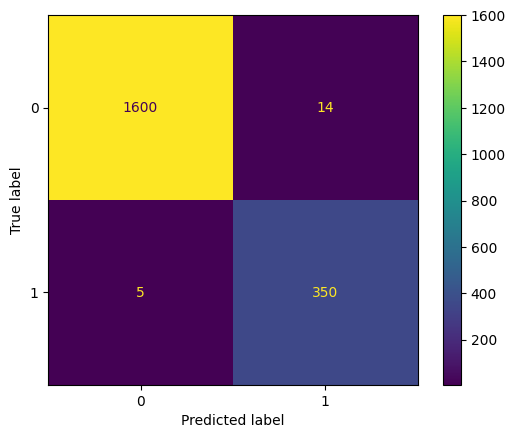

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

In [14]:
trainer.save_model('/content/drive/MyDrive/Project 3 - NLP/model')

Based on the metrics, the model shows a good performance. The high precision and recall values on both training and testing datasets indicate that the model is effective at correctly identifying positive and negative cases.

# Bonus

In [26]:
# Load the emotion analysis dataset
#dataset_file_name = os.path.join('drive','MyDrive','Project 3 - NLP',"emotion_sentimen_dataset.csv")
dataset_file_name = '/content/drive/MyDrive/Project 3 - NLP/emotion_sentimen_dataset.csv'

# Check if the dataset file exists
if not os.path.exists(dataset_file_name):
    raise FileNotFoundError(f"Dataset file not found: {dataset_file_name}")

# Load the dataset and check if it's empty
dataset = pd.read_csv(dataset_file_name)
if dataset.empty:
    raise ValueError("The dataset is empty. Please check the file content.")

# Only use the first 10K entreis
dataset = dataset.head(10000)

In [27]:
# Suppose that we wanted to detect only “surprise” emotion vs all the others.
# Calculate the percentage of “surprise” emotion.
round(dataset['Emotion'][dataset['Emotion']=='surprise'].count()/len(dataset)*100,3)

0.39

There are 0.39% of entries labeled with ‘surprise’, therefore the model is likely to be biased towards the majority class (non-surprise)
We can use data augmentation to synthetically increase its percentage. we could consider oversampling i.e. duplicating these entries so that their representation will synthetically increase. We could also undersample the majority class - ignore some entries from the majority class of ‘neutral’ so that the dataset will be more balanced.
In light of the above, we should focus on precision and recall and not accuracy as the preferred metrics for model evaluation if we would want to classify based on 'surprise' and 'non-surprise'.


In [28]:
# Show the different unique emotions in the dataset
dataset.Emotion.unique()

array(['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness',
       'fun', 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
      dtype=object)

In [29]:
# Let’s try to create a classification of 3 classes - neutral, positive, negative.
# For example “happiness” would be positive, but “sadness” would be negative. How can you easily adjust the ground truth?

def map_emotion_to_three_classes(emotion):
  if emotion == 'neutral':
    return 0  # Neutral
  elif emotion in ['love', 'surprise', 'relief', 'happiness', 'fun', 'enthusiasm']:
    return 1  # Positive
  else:
    return 2  # Negative

# Apply the mapping to the 'Emotion' column
dataset['Emotion'] = dataset['Emotion'].apply(map_emotion_to_three_classes)


In [30]:
dataset

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,2
1,1,im so full of life i feel appalled,0
2,2,i sit here to write i start to dig out my feel...,0
3,3,ive been really angry with r and i feel like a...,2
4,4,i feel suspicious if there is no one outside l...,0
...,...,...,...
9995,9995,i feel quite frustrated that not many people s...,2
9996,9996,i feel as if i might regret my choices one wor...,0
9997,9997,i feel i m just very proud to be an american c...,0
9998,9998,i feel for those faithful members of the parishes,0


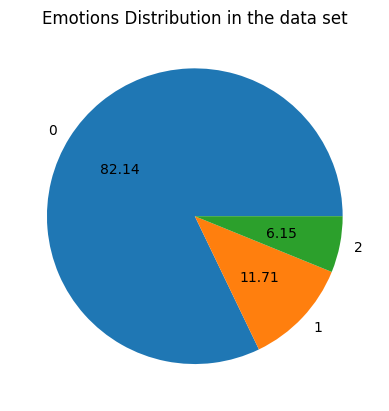

In [36]:
label_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
emotion_counts.index = emotion_counts.index.map(label_mapping)
# group by Emotion and get counts
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%.2f')
plt.title("Emotions Distribution in the data set")
plt.show()

In [37]:
random.seed(42)
dataset['Type'] = ['Train' if random.random() < 0.8 else 'Test' for _ in dataset['Emotion']]

# Split dataset into train and test sets
train_texts = dataset[dataset['Type'] == "Train" ]['text']
train_labels = dataset[dataset['Type'] == "Train" ]['Emotion']

test_texts = dataset[dataset['Type'] == "Test" ]['text']
test_labels = dataset[dataset['Type'] == "Test" ]['Emotion']


In [33]:
# Prepare the dataset for the transformer
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': train_texts,
    'label': train_labels
}))
test_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': test_texts,
    'label': test_labels
}))

# Load pre-trained DistilBERT tokenizer and model
# DistilBERT is chosen for its efficiency in NLP tasks with fewer parameters
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Function that tokenize the dataset with padding and truncation to maintain consistent input sizes
def tokenize_data(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

# Convert labels to LongTensor (important for PyTorch models)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Training the model
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    logging_dir='./logs',
    do_eval=True,
    evaluation_strategy="epoch"
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8031 [00:00<?, ? examples/s]

Map:   0%|          | 0/1969 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Predict outputs for the training dataset
train_output = trainer.predict(train_dataset)
train_predictions = train_output.predictions.argmax(-1)
train_references = train_output.label_ids

# Predict outputs for the testing dataset
test_output = trainer.predict(test_dataset)
test_predictions = test_output.predictions.argmax(-1)
test_references = test_output.label_ids



Epoch,Training Loss,Validation Loss
1,0.155200,0.098284
2,0.071000,0.080933
3,0.027400,0.073338
4,0.016200,0.085106
5,0.004700,0.084654


{'eval_loss': 0.08465384691953659, 'eval_runtime': 7.5418, 'eval_samples_per_second': 261.079, 'eval_steps_per_second': 32.751, 'epoch': 5.0}


Training Precision: 0.9995, Training Recall: 0.9995
Testing Precision: 0.9898, Testing Recall: 0.9898


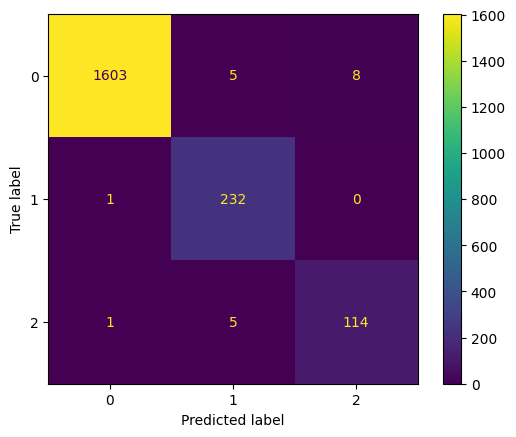

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Function to calculate precision and recall
def compute_precision_recall(predictions, references):
    return (precision_score(references,predictions, average='weighted'), # Change average to 'weighted'
            recall_score(references,predictions, average='weighted')) # Change average to 'weighted'

# Compute precision and recall for the training dataset
train_precision, train_recall = compute_precision_recall(train_predictions, train_references)
print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}")

# Compute precision and recall for the testing dataset
test_precision, test_recall = compute_precision_recall(test_predictions, test_references)
print(f"Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}")

conf_matrix = confusion_matrix(test_predictions, test_references)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

Based on the confusion matrix, the results look good, with negligible FP or FN. In case the FP/FN were higher we could have synthetically balance the dataset by using oversampling of the minority classes, undersampling of the majority class and/or augmenting new data synthetically for the minority class using SMOTE:
```
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
train_texts_resampled, train_labels_resampled = smote.fit_resample(train_texts, train_labels)

# Proceed with resampled data
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': train_texts_resampled,
    'label': train_labels_resampled
}))
```


